In [1]:
import sys, os
import importlib
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [6]:
SRC_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PARENT_DIR)
conf = importlib.import_module('confs.pendulum_conf')
env = getattr(conf, 'PendulumEnv')(conf)


from neural_network import ActorCriticNet
from rl_trainer import RLTrainer
from opt.traj_opt import TrajOpt

ac_net = ActorCriticNet(env, conf)
actor = ac_net.create_actor()
critic = ac_net.create_critic()
TO = TrajOpt(env, conf)

# Load the weights
actor_path = '/home/seyoungree/Documents/GATO-RL/pendulum/2025-07-29_10-24/actor_final.pth'
critic_path = '/home/seyoungree/Documents/GATO-RL/pendulum/2025-07-29_10-24/critic_final.pth'
actor.load_state_dict(torch.load(actor_path, map_location='cpu'))
critic.load_state_dict(torch.load(critic_path, map_location='cpu'))
actor.eval()
critic.eval()

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (2): ELU(alpha=1.0, inplace=True)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (5): ELU(alpha=1.0, inplace=True)
  (6): Linear(in_features=64, out_features=128, bias=True)
  (7): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (8): ELU(alpha=1.0, inplace=True)
  (9): Linear(in_features=128, out_features=128, bias=True)
  (10): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (11): ELU(alpha=1.0, inplace=True)
  (12): Linear(in_features=128, out_features=1, bias=True)
)

In [7]:
%matplotlib inline

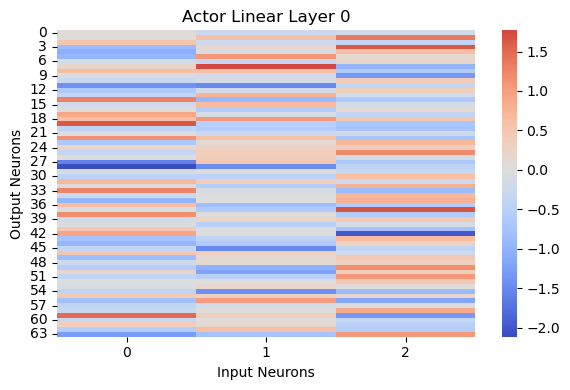

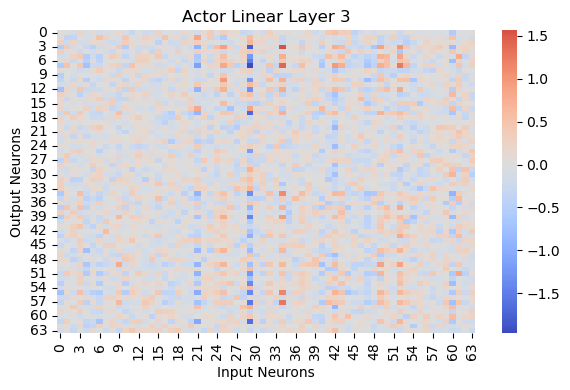

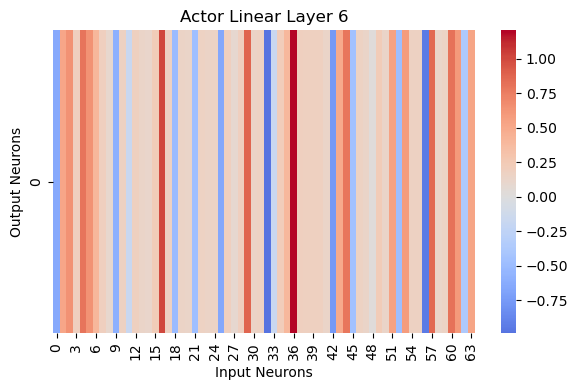

In [8]:
def visualize_weights(weights, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(weights, cmap='coolwarm', center=0)
    plt.title(title)
    plt.xlabel("Input Neurons")
    plt.ylabel("Output Neurons")
    plt.tight_layout()
    plt.show()

def visualize_model_weights(model, name="Model"):
    for i, layer in enumerate(model):
        # Standard linear layer
        if isinstance(layer, nn.Linear):
            w = layer.weight.detach().cpu().numpy()
            visualize_weights(w, f"{name} Linear Layer {i}")
# Visualize
visualize_model_weights(actor, "Actor")

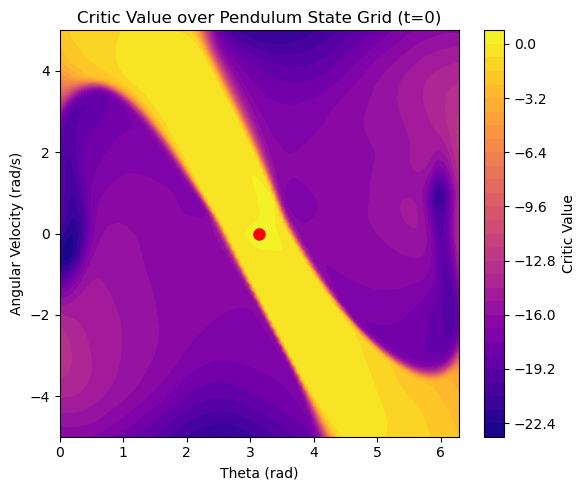

In [9]:
theta_min, w_min = conf.X_INIT_MIN[:2]
theta_max, w_max = conf.X_INIT_MAX[:2]

# Grid over theta and angular velocity
theta = np.linspace(theta_min, theta_max, 100)
w = np.linspace(w_min, w_max, 100)
Theta, W = np.meshgrid(theta, w)
T = np.ones_like(Theta)*0  # time fixed at t=0

# Stack into (N, 3) state vectors
states = np.stack([Theta.ravel(), W.ravel(), T.ravel()], axis=1)
states_tensor = torch.tensor(states, dtype=torch.float32)

# Evaluate critic
with torch.no_grad():
    values = ac_net.eval(critic, states_tensor).cpu().numpy().reshape(Theta.shape)

# Plotting
plt.figure(figsize=(6, 5))
contour = plt.contourf(Theta, W, values, levels=30, cmap='plasma')
plt.colorbar(contour, label='Critic Value')

theta_goal, w_goal = env.goal_state[:2]
plt.plot(theta_goal, w_goal, 'ro', markersize=8, label='Goal State')


plt.xlabel('Theta (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Critic Value over Pendulum State Grid (t=0)')
plt.tight_layout()
plt.show()

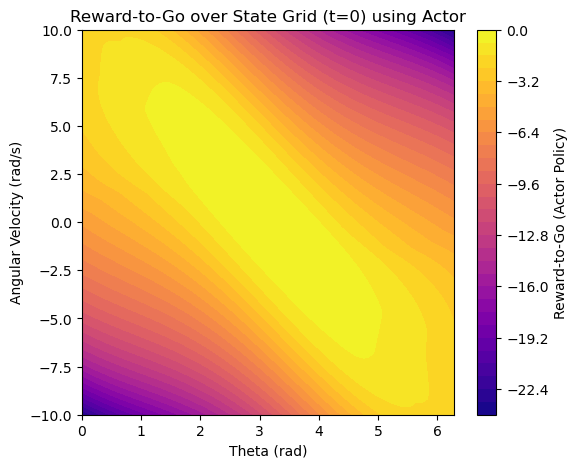

In [6]:
# Compute actual reward-to-go values using compute_partial_rtg for each grid state, with actor actions
rtg_values = np.zeros_like(Theta)
trainer = RLTrainer(env, None, conf, N_try=0)

for idx, (p, v) in enumerate(zip(Theta.ravel(), W.ravel())):
    init_state = np.array([p, v, 0.0])
    states = np.zeros((conf.NSTEPS + 1, conf.nx + 1))
    states[0] = init_state
    actions = np.zeros((conf.NSTEPS, conf.nu))
    for t in range(conf.NSTEPS):
        # Prepare state for actor (batch of 1)
        state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
        with torch.no_grad():
            action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
        actions[t] = action
        # Simulate next state
        states[t + 1] = env.simulate(states[t], actions[t])
        # states[t + 1, :2] = 0
    _, rtg, _, _, _ = trainer.compute_partial_rtg(actions, states)
    rtg_values.ravel()[idx] = rtg[0]

# Plot the RTG values
plt.figure(figsize=(6,5))
contour = plt.contourf(Theta, W, rtg_values, levels=30, cmap='plasma')
plt.colorbar(contour, label='Reward-to-Go (Actor Policy)')
plt.xlabel('Theta (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Reward-to-Go over State Grid (t=0) using Actor')
plt.show()

   t |        x |        v |        u
----------------------------------------
   0 |    1.571 |    1.000 |    5.000
   1 |    1.581 |    0.952 |    5.000
   2 |    1.590 |    0.904 |    5.000
   3 |    1.599 |    0.856 |    5.000
   4 |    1.608 |    0.808 |    5.000
   5 |    1.616 |    0.760 |    5.000
   6 |    1.624 |    0.712 |    5.000
   7 |    1.631 |    0.664 |    5.000
   8 |    1.637 |    0.616 |    5.000
   9 |    1.643 |    0.568 |    5.000
  10 |    1.649 |    0.520 |    5.000
  11 |    1.654 |    0.472 |    5.000
  12 |    1.659 |    0.424 |    5.000
  13 |    1.663 |    0.377 |    5.000
  14 |    1.667 |    0.329 |    5.000
  15 |    1.670 |    0.281 |    5.000
  16 |    1.673 |    0.234 |    5.000
  17 |    1.676 |    0.186 |    5.000
  18 |    1.677 |    0.139 |    5.000
  19 |    1.679 |    0.091 |    5.000
  20 |    1.680 |    0.044 |    5.000
  21 |    1.680 |   -0.004 |    5.000
  22 |    1.680 |   -0.051 |    5.000
  23 |    1.680 |   -0.099 |    5.000
  24 |   

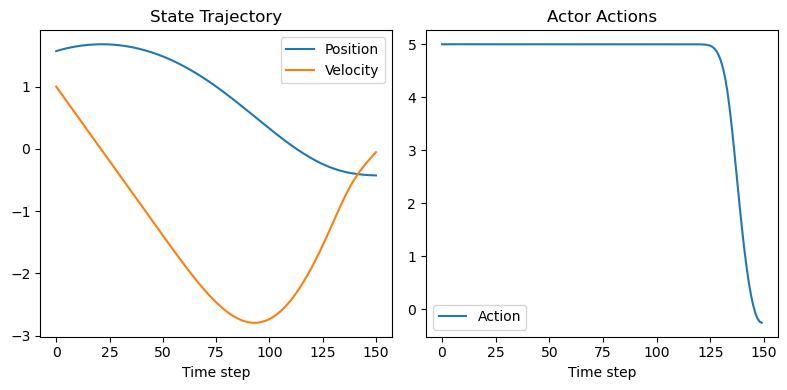

In [10]:
# Test the actor with a single trajectory rollout from an initial state
T = 1.5
steps = conf.NSTEPS - int(T / conf.dt)
init_state = np.array([np.pi/2, 1, T])  # Example initial state: [position, velocity, time]
states = np.zeros((steps + 1, conf.nx + 1))
states[0] = init_state
actions = np.zeros((steps, conf.nu))

print(f"{'t':>4} | {'x':>8} | {'v':>8} | {'u':>8}")
print("-" * 40)

for t in range(steps):
    state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
    with torch.no_grad():
        action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
    print(f"{t:4d} | {states[t, 0]:8.3f} | {states[t, 1]:8.3f} | {action:8.3f}")
    actions[t] = action
    states[t + 1] = env.simulate(states[t], actions[t])

# Plot the trajectory
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(states[:,0], label='Position')
plt.plot(states[:,1], label='Velocity')
plt.xlabel('Time step')
plt.title('State Trajectory')
plt.legend()

plt.subplot(1,2,2)
plt.plot(actions, label='Action')
plt.xlabel('Time step')
plt.title('Actor Actions')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
import matplotlib.colors as mcolors
theta_vals = np.linspace(conf.X_INIT_MIN[0], conf.X_INIT_MAX[0], 10)
omega_vals = np.linspace(conf.X_INIT_MIN[1], conf.X_INIT_MAX[1], 10)
T = 2.0
nx, nu = conf.nx, conf.nu
trainer = RLTrainer(env, ac_net, conf, 0)

cost_actor = np.zeros((len(omega_vals), len(theta_vals)))
cost_zero = np.zeros_like(cost_actor)
iters_actor = np.zeros_like(cost_actor)
iters_zero = np.zeros_like(cost_actor)

for i, w in enumerate(omega_vals):
    for j, th in enumerate(theta_vals):
        steps = conf.NSTEPS - int(T / conf.dt)
        init_state = np.array([th, w, T])

        # Actor rollout
        states = np.zeros((steps + 1, nx + 1))
        actions = np.zeros((steps, nu))
        states[0] = init_state

        for t in range(steps):
            state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
            with torch.no_grad():
                action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
            actions[t] = action
            states[t + 1] = env.simulate(states[t], actions[t])

        # TO with actor warmstart
        opt_states, opt_actions, iters_a, _ = TO.solve_pend_constrained_SQP(
            states, actions, display_flag=False
        )
        N = opt_states.shape[0]
        num_vars = (N - 1) * (nx + nu) + nx
        x_guess = np.zeros((num_vars, 1))
        for k in range(N - 1):
            idx = k * (nx + nu)
            x_guess[idx:idx + nx, 0] = opt_states[k, :2]
            x_guess[idx + nx, 0] = opt_actions[k, 0]
        x_guess[-nx:, 0] = opt_states[-1, :2]
        cost_actor[i, j] = env.running_cost(x_guess)
        iters_actor[i, j] = iters_a
        
        # TO with zero warmstart
        zero_states, zero_actions, _ = trainer.create_TO_init(0, states[0])

        opt_states, opt_actions, iters_z, _ = TO.solve_pend_constrained_SQP(
            zero_states, zero_actions, display_flag=False
        )
        N = opt_states.shape[0]
        x_guess = np.zeros((num_vars, 1))
        for k in range(N - 1):
            idx = k * (nx + nu)
            x_guess[idx:idx + nx, 0] = opt_states[k, :2]
            x_guess[idx + nx, 0] = opt_actions[k, 0]
        x_guess[-nx:, 0] = opt_states[-1, :2]
        cost_zero[i, j] = env.running_cost(x_guess)
        iters_zero[i, j] = iters_z


# Compute differences
cost_diff = cost_zero - cost_actor
iters_diff = iters_zero - iters_actor

/tmp/ipykernel_68248/2716526822.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost_actor[i, j] = env.running_cost(x_guess)
/tmp/ipykernel_68248/2716526822.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost_zero[i, j] = env.running_cost(x_guess)


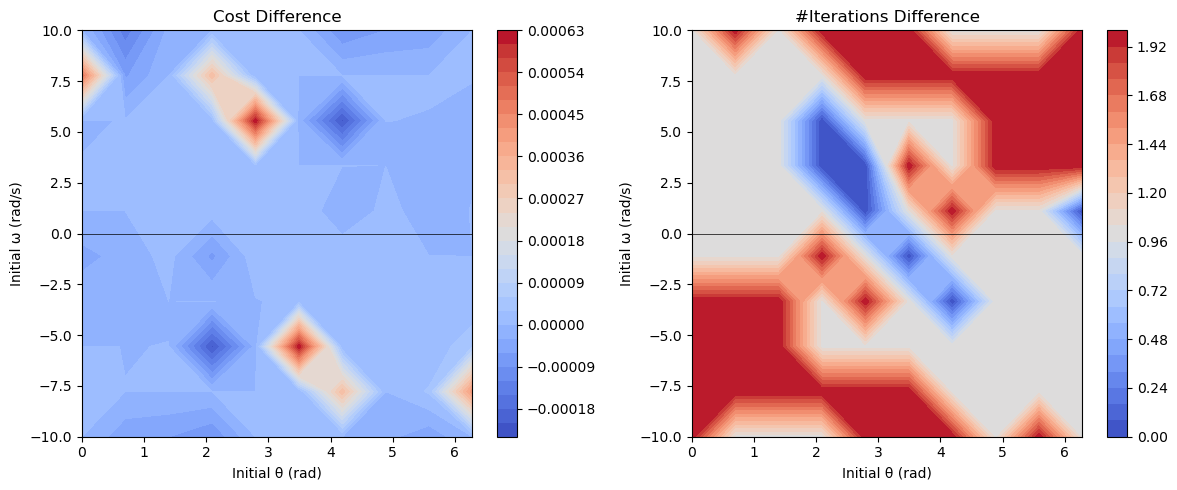

In [14]:
# --- Plot side-by-side ---
Theta, Omega = np.meshgrid(theta_vals, omega_vals, indexing='xy')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_xlim(theta_vals[0], theta_vals[-1])
axs[0].set_ylim(omega_vals[0], omega_vals[-1])
axs[1].set_xlim(theta_vals[0], theta_vals[-1])
axs[1].set_ylim(omega_vals[0], omega_vals[-1])
c1 = axs[0].contourf(Theta, Omega, cost_diff, levels=30, cmap='coolwarm')
fig.colorbar(c1, ax=axs[0])
axs[0].set_title('Cost Difference')
axs[0].set_xlabel('Initial θ (rad)')
axs[0].set_ylabel('Initial ω (rad/s)')
axs[0].axhline(0, color='black', linewidth=0.5)
axs[0].axvline(0, color='black', linewidth=0.5)

c2 = axs[1].contourf(Theta, Omega, iters_diff, levels=30, cmap='coolwarm')
fig.colorbar(c2, ax=axs[1])
axs[1].set_title('#Iterations Difference')
axs[1].set_xlabel('Initial θ (rad)')
axs[1].set_ylabel('Initial ω (rad/s)')
axs[1].axhline(0, color='black', linewidth=0.5)
axs[1].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()


In [15]:
iters_diff

array([[2., 1., 1., 1., 2., 2., 2., 1., 2., 1.],
       [2., 2., 2., 2., 2., 2., 1., 1., 1., 1.],
       [2., 2., 2., 1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 1., 2., 1., 0., 1., 1., 1.],
       [1., 1., 1., 2., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 2., 1., 1., 0.],
       [1., 1., 1., 0., 0., 2., 1., 2., 2., 2.],
       [1., 1., 1., 0., 1., 1., 1., 2., 2., 2.],
       [1., 1., 1., 1., 2., 2., 2., 2., 2., 2.],
       [1., 2., 1., 2., 2., 2., 1., 1., 1., 2.]])

In [16]:
cost_diff.sum()

np.float64(0.0017146308867062032)

In [17]:
iters_diff.sum()

np.float64(131.0)